Dataset Info
===

This notebook displays summary info about the dataset. Specifically it looks at:

 - **Segment Label Distributions:** The vocabulary of and frequency at which segment labels occurs
 - **Segment Length Distributions:** The distribution of lengths of various segments in the dataset
 - **Beat / Tempo Distributions:** The lengths of beats per track and across tracks in the dataset
 - **Time Signature Distributions:** The number of beats within each bar within each track and across tracks
 - **Time Signature / Tempo Change Frequency:** The frequency of multimodal tempos and beat per bar numbers within each track - Still to do.
 - **Segmentation Experiments:** Running MSAF algorithms with different sets of beat annotations/estimations.


Reading in Data
===

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Configure pandas display
pd.options.display.max_rows = 5

# Define dataset info
DATA_DIR = os.path.abspath('../dataset/')
BEAT_DIR = os.path.join(DATA_DIR, 'beats')
BEAT_MARKER_COLUMN = 'BeatMarker'
BEAT_NUMBER_COLUMN = 'BeatNumber'
BAR_NUMBER_COLUMN = 'BarNumber'
BEATS_COLUMNS = [BEAT_MARKER_COLUMN, BEAT_NUMBER_COLUMN, BAR_NUMBER_COLUMN]
SEGMENT_DIR = os.path.join(DATA_DIR, 'segments')
SEG_BOUNDARY_COLUMN = 'SegmentStart'
SEG_LABEL_COLUMN = 'SegmentLabel'
SEGMENTS_COLUMNS = [SEG_BOUNDARY_COLUMN, SEG_LABEL_COLUMN]

# Load entire dataset into memory
beat_files = [os.path.join(BEAT_DIR, fname) for fname in os.listdir(BEAT_DIR)]
seg_files = [os.path.join(SEGMENT_DIR, fname) for fname in os.listdir(SEGMENT_DIR)]
beat_data = {os.path.basename(fname):pd.read_csv(fname, names=BEATS_COLUMNS, delimiter='\t') for fname in beat_files}
seg_data = {os.path.basename(fname):pd.read_csv(fname, names=SEGMENTS_COLUMNS, delimiter=' ') for fname in seg_files}

# Display some data
print("Tempo Data Sample:")
print("===")
print(" ")
for key, value in list(beat_data.items())[:1]:
    print(key)
    display(value)
print(" ")
print(" ")
print(" ")
print("Segmentation Data Sample:")
print("===")
print(" ")
for key, value in list(seg_data.items())[:1]:
    print(key)
    display(value)
    
%matplotlib inline

Tempo Data Sample:
===
 
0001_12step.txt


,BeatMarker,BeatNumber,BarNumber
0,0.000000,1,1
1,0.530973,2,1
...,...,...,...
259,137.531079,4,65
260,138.062064,1,66


 
 
 
Segmentation Data Sample:
===
 
0001_12step.txt


,SegmentStart,SegmentLabel
0,0.000000,intro
1,8.495568,verse
...,...,...
8,129.565932,outro
9,138.062064,end


In [5]:
len(seg_data['0004_abc.txt'])

10

All Labels:
{'intro2', 'gtr2', 'gtr', 'verse1a', 'prechors', 'verse', 'verseinst', 'silence', 'choruspart', 'prehorus', 'outro', 'section9', 'section6', 'slow', 'drumroll', 'prechorus', 'postverse', 'transtiion', 'prechorus5', 'miniverse', 'breakdown', 'instchorus', 'break2', 'section13', 'break3', 'chorushalf', 'section14', 'worstthingever', 'bridge', 'chrous2', 'intro3', 'bre', 'section7', 'section17', 'intro8', 'instrumental2', 'section11', 'guitarsolo', 'outro1', 'verse1', 'raps', 'verse_slow', 'section12', 'introverse', 'guitar', 'saxobeat', 'section4', 'section8', 'verse5', 'section16', 'quiet', 'outro2', 'bridge2', 'mainriff2', 'break1', 'prechorus2', 'transition', 'verse3', 'verse6', 'bigoutro', 'section10', 'intro', 'preverse', 'verse9', 'section5', 'transition1', 'bridge1', 'intro4', 'chorus', 'mainriff', 'versepart', 'break', 'altchorus', 'isnt', 'end', 'chorus2', 'solo2', 'introchorus', 'opening', 'chorus3', 'transition2', 'section15', 'intro7', 'outro3', 'rhythmlessintro',

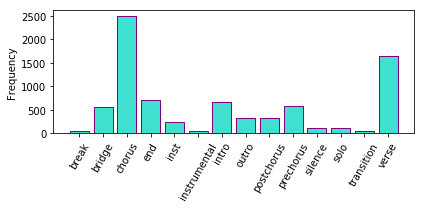

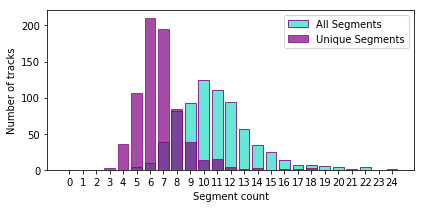

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import collections

# Define Plotting Function
def dict_to_bar(data, title, xlabel, ylabel, fontsize=10, alpha=1, label="plot", 
                color="blue", edgecolor="blue"):
    data = collections.OrderedDict(sorted(data.items()))
    idxs = np.arange(len(data.values()))
    plt.bar(idxs, data.values(), alpha=alpha, label=label, 
            color=color, edgecolor=edgecolor)
    ax = plt.axes()
    ax.set_xticks(idxs)
    ax.set_xticklabels(data.keys())
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

# Label Vocabulary
labels = set()
for _, df in seg_data.items():
    labels |= set(df[SEG_LABEL_COLUMN])
print('All Labels:')
print(labels)
print(' ')

# Label Counts
label_dict = {label: 0 for label in labels}
for _, df in seg_data.items():
    for item in df[SEG_LABEL_COLUMN]:
        label_dict[item] += 1
print("Dict size:", len(label_dict.keys()))
filtered_label_dict = {key: value for key, value in label_dict.items() if value > 50 and key != 'section'} # <= Filter out labels that only occur once
plt.figure(figsize=(6, 3))
dict_to_bar(filtered_label_dict,
            'Frequency of Segment Labels',
            '',
            'Frequency',
            color='turquoise',
            edgecolor='purple',
            label='All Segments')
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig('../results/SegmentLabels_distribution.pdf')

# Segments per Track
num_segs = collections.defaultdict(int)
for _, df in seg_data.items():
    num = len(df.index) - 1 # <= Every track has an extra "end" label marking the end, not start, of a segment.
    num_segs[num] += 1
print("num segs", num_segs)
num_segs = {count:num_segs[count] for count in range(max(num_segs.keys()))}
plt.figure(figsize=(6, 3))
dict_to_bar(num_segs,
            'Distribution of Total Number of Segments per Track',
            'Number Segments in Track',
            'Number Tracks',
            alpha=0.8, 
            color='turquoise',
            edgecolor='purple',
            label='All Segments')

# Number of Labels per Track
unique_labels = collections.defaultdict(int)
for _, df in seg_data.items():
    labels = set(df[SEG_LABEL_COLUMN])
    unique_labels[len(labels)] += 1
unique_labels = {count:unique_labels[count] for count in range(max(unique_labels.keys()))}
dict_to_bar(unique_labels,
            'Unique Labels per Track in Dataset',
            'Segment count',
            'Number of tracks',
            alpha=0.7,
            color='purple',
            edgecolor='purple',
            label='Unique Segments')
plt.tight_layout()
plt.legend()
plt.savefig('../results/segment_label_count.pdf')

# TODO: Some indication of label repetition per track? - This may be a comparison of the two immediately preceding graphs above

# TODO: How many segments that start on downbeats?

Segment Length Distributions
===

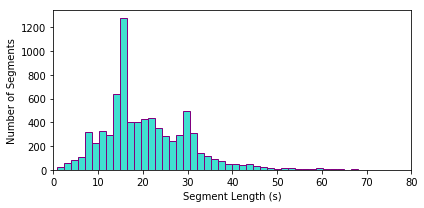

In [13]:
# Plot distribution of length of all segments
lengths = []
for c, df in seg_data.items():
    this_track_lens = np.array(df[SEG_BOUNDARY_COLUMN])
    lengths += [this_track_lens[1:] - this_track_lens[:-1]]
lengths = np.concatenate(lengths)
bins = 100
plt.figure(figsize=(6, 3))
plt.hist(lengths, bins, color='turquoise', edgecolor='purple')
plt.xlabel('Segment Length (s)')
plt.ylabel('Number of Segments')
plt.xlim((0, 80))
plt.tight_layout()
plt.savefig('../results/SegmentLength_distribution.pdf')

# TODO: Some indication of segment length on a per-track basis, as opposed to aggregated across dataset?

Beat / Tempo Distribution
===

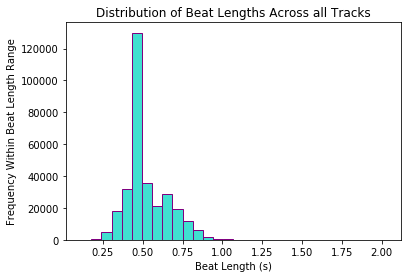

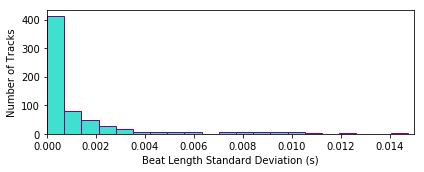

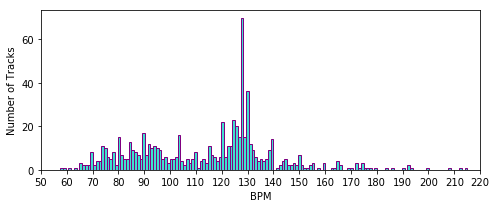

In [14]:
# Plot distribution of beat lengths across entire dataset
color = "turquoise"
edgecolor = "purple"
lengths = []
for _, df in beat_data.items():
    this_track_lens = np.array(df[BEAT_MARKER_COLUMN])
    lengths += [this_track_lens[1:] - this_track_lens[:-1]]
all_lengths = np.concatenate(lengths)
bins = 30
plt.hist(all_lengths, bins, color=color, edgecolor=edgecolor)
plt.title('Distribution of Beat Lengths Across all Tracks')
plt.xlabel('Beat Length (s)')
plt.ylabel('Frequency Within Beat Length Range')

# Plot distribution of variance in beat length within each track
beat_stds = np.array([np.std(track_beat_lens) for track_beat_lens in lengths])
bins = 200
plt.figure(figsize=(6, 2.5))
plt.hist(beat_stds, bins, align='mid', color=color, edgecolor=edgecolor)
# plt.title('Distribution of Beat Length Standard Deviation Within Each Track')
plt.xlabel('Beat Length Standard Deviation (s)')
plt.ylabel('Number of Tracks')
plt.xlim((0, 0.015))
plt.tight_layout()
plt.savefig('../results/BPM_std.pdf')

# Plot distribution of tempo (taken as median beat length for each track)
tempos = np.array([60.0/np.median(track_beat_lens) for track_beat_lens in lengths])
bins = 200
plt.figure(figsize=((7, 3)))
plt.hist(tempos, bins, color=color, edgecolor=edgecolor)
plt.xlabel('BPM')
plt.ylabel('Number of Tracks')
# ax = plt.gca()
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
plt.xticks(np.arange(0, 250, 10))
plt.xlim((50, 220))
plt.tight_layout()
plt.savefig('../results/BPM_distribution.pdf')

Time Signature Distribution
===

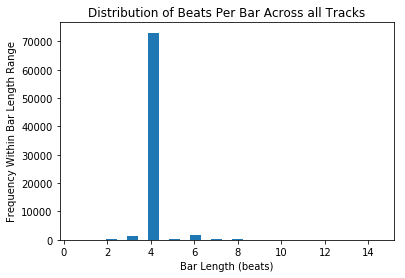

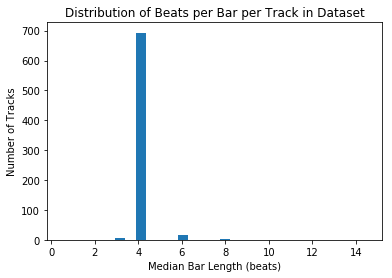

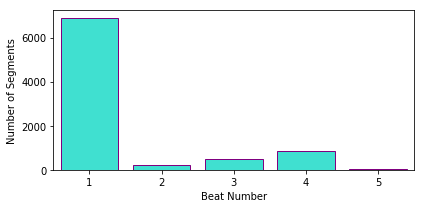

In [15]:
# Plot the distribution of beats per bar aggregated across tracks
beats_per_bar_each_track = []
for _, df in beat_data.items():
    bar_numbers = np.array(df[BAR_NUMBER_COLUMN])
    bar_end_idxs = np.argwhere((bar_numbers[1:]-bar_numbers[:-1])>0) # <= We ignore the last bar as it is usually incomplete - e.g., the final beat
    beat_numbers = np.array(df[BEAT_NUMBER_COLUMN])
    beats_per_bar_each_track += [beat_numbers[bar_end_idxs]]
all_bars = np.concatenate(beats_per_bar_each_track)
bins = 29
hist_range = (np.min(all_bars)-0.5, np.max(all_bars)+0.5)
plt.hist(all_bars, bins, range=hist_range)
plt.title('Distribution of Beats Per Bar Across all Tracks')
plt.xlabel('Bar Length (beats)')
plt.ylabel('Frequency Within Bar Length Range')

# Plot the distribution of beats per bar per track
time_sigs = np.array([np.median(track_bar_lens) for track_bar_lens in beats_per_bar_each_track])
bins = 29
hist_range = (np.min(all_bars)-0.5, np.max(all_bars)+0.5)
plt.figure()
plt.hist(time_sigs, bins, range=hist_range)
plt.title('Distribution of Beats per Bar per Track in Dataset')
plt.xlabel('Median Bar Length (beats)')
plt.ylabel('Number of Tracks')

# Find the beat index for each segment
seg_start_beats = []
for beat_df, seg_df in zip(beat_data.values(), seg_data.values()):
    seg_start_beats += [[]]
    for seg_time in seg_df['SegmentStart']:
        seg_start_beats[-1] += [np.argmin(np.abs(np.array(beat_df['BeatMarker'].values) - seg_time))]
        
        
beat_idxs = {
    '1':0,
    '2':0,
    '3':0,
    '4':0,
    '5':0,
    '6':0,
}
for seg_start_idxs, beat_df in zip(seg_start_beats, beat_data.values()):
    for idx in seg_start_idxs:
        beat_idxs[str(beat_df['BeatNumber'].values[idx])] += 1
        
plt.figure(figsize=(6, 3))
dict_to_bar(beat_idxs,
            'Beat Number of Segment Beginning',
            'Beat Number',
            'Number of Segments',
            color='turquoise',
            edgecolor='purple')
plt.tight_layout()
plt.xlim((-0.5, 4.5))
plt.savefig('../results/Downbeat_Segment_Alignment.pdf')

#     bar_numbers = np.array(df[BAR_NUMBER_COLUMN])
#     bar_end_idxs = np.argwhere((bar_numbers[1:]-bar_numbers[:-1])>0) # <= We ignore the last bar as it is usually incomplete - e.g., the final beat
#     beat_numbers = np.array(df[BEAT_NUMBER_COLUMN])
#     beats_per_bar_each_track += [beat_numbers[bar_end_idxs]]
# all_bars = np.concatenate(beats_per_bar_each_track)


Tempo Change / Time Signature Change
===

In [71]:
# TODO: Search for tempo changes by finding significant deviations from the beat in the middle of a track

# TODO: Search for time signature changes by finding any bars with different counts to any other bar in a track

# Segmentation Data

In [2]:
import seaborn as sns

sns.set_style("darkgrid")

SEGMENTATION_RESULTS_KWSKI = "../results/korz_beats.csv"
SEGMENTATION_RESULTS_ANNB = "../results/annot_beats.csv"
SEGMENTATION_RESULTS_LIBROSA = "../results/librosa_beats.csv"

In [3]:
kwski_df = pd.read_csv(SEGMENTATION_RESULTS_KWSKI)
librosa_df = pd.read_csv(SEGMENTATION_RESULTS_LIBROSA)
ann_df = pd.read_csv(SEGMENTATION_RESULTS_ANNB)

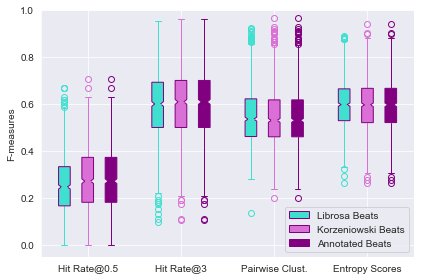

In [4]:
fig, ax = plt.subplots()

c1 = "turquoise"
box1 = ax.boxplot((librosa_df["HitRate_0.5F"], 
             librosa_df["HitRate_3F"],
             librosa_df["PWF"], 
             librosa_df["Sf"]),
            positions=[1, 5, 9, 13],
            notch=True, patch_artist=True,
            boxprops=dict(facecolor=c1, color="purple"),
            capprops=dict(color=c1),
            whiskerprops=dict(color=c1),
            flierprops=dict(color=c1, markeredgecolor=c1),
            medianprops=dict(color=c1))

c2 = "orchid"
box2 = ax.boxplot((kwski_df["HitRate_0.5F"], 
             kwski_df["HitRate_3F"],
             kwski_df["PWF"], 
             kwski_df["Sf"]),
            positions=[2, 6, 10, 14],
            notch=True, patch_artist=True,
            boxprops=dict(facecolor=c2, color="purple"),
            capprops=dict(color=c2),
            whiskerprops=dict(color=c2),
            flierprops=dict(color=c2, markeredgecolor=c2),
            medianprops=dict(color=c2))

c3 = "purple"
box3 = ax.boxplot((ann_df["HitRate_0.5F"], 
             ann_df["HitRate_3F"],
             ann_df["PWF"], 
             ann_df["Sf"]),
            positions=[3, 7, 11, 15],
            notch=True, patch_artist=True,
            boxprops=dict(facecolor=c3, color=c3),
            capprops=dict(color=c3),
            whiskerprops=dict(color=c3),
            flierprops=dict(color=c3, markeredgecolor=c3),
            medianprops=dict(color=c3))
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(box3[item], color=c3)
plt.setp(box3["boxes"], facecolor=c3)
plt.setp(box3["fliers"], markeredgecolor=c3)

ax.legend([box1["boxes"][0], box2["boxes"][0], box3["boxes"][0]], 
          ['Librosa Beats', 'Korzeniowski Beats', 'Annotated Beats'], 
          loc='lower right')

plt.xticks([2, 6, 10, 14], ["Hit Rate@0.5", "Hit Rate@3", "Pairwise Clust.", "Entropy Scores"])
plt.xlim(0, 16)
plt.ylim(-0.05, 1)

plt.ylabel("F-measures")
plt.tight_layout()
plt.savefig("../paper/figs/segment_results.pdf")